In [1]:
# %%capture cap
!pip install -q ipywidgets
!pip install -q autogluon scikit-learn==1.5.2 
!apt-get install -q -y graphviz graphviz-dev && pip install -q pydot
!pip install -q pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 8.6 MB/s eta 0:00

In [2]:
import torch
import os
import pydot

import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import time, sleep
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 500)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

print("Packages import succesful!")

Packages import succesful!


In [3]:
### Load Data ###
PATH = '/kaggle/input/playground-series-s5e12/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv").drop('id', axis=1)

TARGET = train.columns[-1]
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
BASE = NUMS + CATS

ORIG_PATH = '/kaggle/input/diabetes-health-indicators-dataset/'
orig = pd.read_csv(ORIG_PATH+'diabetes_dataset.csv')

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (700000, 25)
Test shape: (300000, 24)
Original shape: (100000, 31)

Total Numerical: 18
Total Categorical: 6
Total base features: 24


In [4]:
## -- Define categories for OHE --
CAT_COLS = [c for c in BASE if train[c].dtype=='object' or train[c].nunique() <= 0.01*len(train)]
print(f"ℹ️ Features for TE: {len(CAT_COLS)} -> {CAT_COLS}")

ℹ️ Features for TE: 24 -> ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


In [5]:
# ROUND = []
# for col in tqdm(['annual_income', 'loan_amount']):
#     for r in [-3, -2, -1, 0]:
#         n = f"{col}_r{r}"
#         train[n] = train[col].round(r).astype(int)
#         test[n] = test[col].round(r).astype(int)
#         orig[n] = test[col].round(r).astype(int)
#         ROUND.append(n)

# print(f'{len(ROUND)} ROUND Features created.')
# print(train[ROUND].nunique())

# DIGITS = []
# for col in tqdm(['debt_to_income_ratio']):
#     for d in range(1, 4):
#         n = f'{col}_d{d}'
#         train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
#         test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
#         orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

#         ## -- Drop constant features --
#         if train[n].nunique() < 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             DIGITS.append(n)

# for col in tqdm(['interest_rate']):
#     for d in range(1, 3):
#         n = f'{col}_d{d}'
#         train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
#         test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
#         orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

#         ## -- Drop constant features --
#         if train[n].nunique() < 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             DIGITS.append(n)

# print(f'{len(DIGITS)} Features DIGITS extracted.')
# print(train[DIGITS].nunique())

# INTER = []
# for col1, col2 in tqdm(list(combinations(CAT_COLS+DIGITS, 2)), desc="Pairwise"):
#     new_col = f"{col1}-|-{col2}"
#     train[new_col] = train[col1].astype(str) + '_' + train[col2].astype(str)
#     test[new_col] = test[col1].astype(str) + '_' + test[col2].astype(str)
#     orig[new_col] = orig[col1].astype(str) + '_' + orig[col2].astype(str)
#     INTER.append(new_col)

# print(f"Ineraction Features: {len(INTER)}")

In [6]:
# ORIG = []

# for col in tqdm(BASE):
#     # MEAN
#     mean_map = orig.groupby(col)[TARGET].mean()
#     mean_col = f"OTE_{col}_mean"
#     mean_map.name = mean_col

#     train = train.merge(mean_map, on=col, how='left')
#     test = test.merge(mean_map, on=col, how='left')
#     ORIG.append(mean_col)

#     # COUNT
#     count_col = f"OTE_{col}_count"
#     count_map = orig.groupby(col).size().reset_index(name=count_col)

#     train = train.merge(count_map, on=col, how='left')
#     test = test.merge(count_map, on=col, how='left')
#     ORIG.append(count_col)

# print(len(ORIG), 'Orig Features Created!!')

In [7]:
# combined = pd.concat([train, test, orig], ignore_index=True)
    
# ## 1. CONVERT ALL NUMS TO CATEGORY --
# for c in NUMS:
#     combined[c] = combined[c].astype(str)

# ## 2. DUPLICATE ALL NUMS AND CONVERT TO CATEGORY --
# for c in NUMS:
#     combined[f'cat_{c}'] = combined[c].astype(str)

# ## 3. CONVERT ALL CATS TO NUMERICS --
# for c in CATS:
#     combined[c] = combined[c].factorize()[0]
    
# train = combined[:len(train)]
# test  = combined[len(train):len(train)+len(test)]
# orig  = combined[-len(orig):]

# orig.shape, train.shape, test.shape

In [8]:
display(train.head())
train.info()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,85,206,49,131,124,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 700000 non-null  int64  
 1   alcohol_consumption_per_week        700000 non-null  int64  
 2   physical_activity_minutes_per_week  700000 non-null  int64  
 3   diet_score                          700000 non-null  float64
 4   sleep_hours_per_day                 700000 non-null  float64
 5   screen_time_hours_per_day           700000 non-null  float64
 6   bmi                                 700000 non-null  float64
 7   waist_to_hip_ratio                  700000 non-null  float64
 8   systolic_bp                         700000 non-null  int64  
 9   diastolic_bp                        700000 non-null  int64  
 10  heart_rate                          700000 non-null  int64  
 11  cholesterol_total         

In [9]:
display(test.head())
# test.info()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
0,45,4,100,4.3,6.8,6.2,25.5,0.84,123,70,64,209,55,135,111,Female,White,Highschool,Middle,Former,Employed,0,0,0
1,35,1,87,3.5,4.6,9.0,28.6,0.88,120,74,59,159,47,83,145,Female,White,Highschool,Middle,Never,Unemployed,0,0,0
2,45,1,61,7.6,6.8,7.0,28.5,0.94,112,71,75,173,43,99,184,Male,White,Highschool,Low,Never,Employed,0,0,0
3,55,2,81,7.3,7.3,5.0,26.9,0.91,114,81,61,203,59,116,128,Male,White,Graduate,Middle,Former,Employed,0,0,0
4,77,2,29,7.3,7.6,8.5,22.0,0.83,131,78,79,177,59,87,133,Male,White,Graduate,Low,Current,Unemployed,0,0,0


In [10]:
MODELS_PATH = "/kaggle/working/AG_DIABETES_models/"
# !rm -r {MODELS_PATH}

In [11]:
from autogluon.tabular import TabularPredictor

In [12]:
## -- RUN 1: Use train data -- 
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "binary",
          eval_metric = "roc_auc",
                 path = MODELS_PATH,
    ).fit(
                   train_data = train,
                      presets = "best",
                num_bag_folds = 10,
             # dynamic_stacking = False,
             # num_stack_levels = 1,
                   time_limit = 3600*11,
                   # auto_stack = False,
                 # num_bag_sets = 2,
                  # ag_args_fit = {'num_cpus': os.cpu_count()},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Sep 27 10:16:09 UTC 2025
CPU Count:          4
Memory Avail:       29.78 GB / 31.35 GB (95.0%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=10, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon 

(_ray_fit pid=737) [1000]	valid_set's binary_logloss: 0.594859
(_ray_fit pid=736) [1000]	valid_set's binary_logloss: 0.594974 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=737) [2000]	valid_set's binary_logloss: 0.593756 [repeated 2x across cluster]
(_ray_fit pid=736) [2000]	valid_set's binary_logloss: 0.593778 [repeated 2x across cluster]
(_ray_fit pid=737) [3000]	valid_set's binary_logloss: 0.593314 [repeated 2x across cluster]
(_ray_fit pid=734) [3000]	valid_set's binary_logloss: 0.595715 [repeated 2x across cluster]
(_ray_fit pid=737) [4000]	valid_set's binary_logloss: 0.592942 [repeated 2x across cluster]
(_ray_fit pid=734) [4000]	valid_set's binary_logloss: 0.595411 [repeated 2x across cluster]
(_ray_fit pid=735) [5000]	valid_set's binary_logloss: 0.594559 [repeated 2x acro

(_dystack pid=413) 	0.7097	 = Validation score   (roc_auc)
(_dystack pid=413) 	1769.89s	 = Training   runtime
(_dystack pid=413) 	872.78s	 = Validation runtime
(_dystack pid=413) Fitting model: LightGBM_BAG_L1 ... Training model for up to 4787.49s of the 8086.90s of remaining time.
(_dystack pid=413) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.88%)


(_ray_fit pid=1547) [1000]	valid_set's binary_logloss: 0.581299
(_ray_fit pid=1549) [1000]	valid_set's binary_logloss: 0.582911
(_ray_fit pid=1549) [2000]	valid_set's binary_logloss: 0.582652 [repeated 3x across cluster]
(_ray_fit pid=1711) [1000]	valid_set's binary_logloss: 0.583827
(_ray_fit pid=1747) [1000]	valid_set's binary_logloss: 0.585825
(_ray_fit pid=1824) [1000]	valid_set's binary_logloss: 0.58122 [repeated 2x across cluster]
(_ray_fit pid=1748) [2000]	valid_set's binary_logloss: 0.580582
(_ray_fit pid=1747) [2000]	valid_set's binary_logloss: 0.585642
(_ray_fit pid=1871) [1000]	valid_set's binary_logloss: 0.5854
(_ray_fit pid=1871) [2000]	valid_set's binary_logloss: 0.584944
(_ray_fit pid=1919) [1000]	valid_set's binary_logloss: 0.584283


(_dystack pid=413) 	0.727	 = Validation score   (roc_auc)
(_dystack pid=413) 	348.23s	 = Training   runtime
(_dystack pid=413) 	69.3s	 = Validation runtime
(_dystack pid=413) Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 4430.62s of the 7730.02s of remaining time.
(_dystack pid=413) 	0.7009	 = Validation score   (roc_auc)
(_dystack pid=413) 	188.79s	 = Training   runtime
(_dystack pid=413) 	23.89s	 = Validation runtime
(_dystack pid=413) Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 4214.40s of the 7513.81s of remaining time.
(_dystack pid=413) 	0.7014	 = Validation score   (roc_auc)
(_dystack pid=413) 	204.72s	 = Training   runtime
(_dystack pid=413) 	23.02s	 = Validation runtime
(_dystack pid=413) Fitting model: CatBoost_BAG_L1 ... Training model for up to 3981.24s of the 7280.65s of remaining time.
(_dystack pid=413) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, mem

In [13]:
## -- Get Summary -- 
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}\n") 

## -- Observe RUN 1 RESULTS -- 
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 28
-> Best model   : WeightedEnsemble_L3



,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.728944,roc_auc,1538.945742,27146.089392,0.146707,93.405684,3,True,28
1,NeuralNetFastAI_BAG_L2,0.728818,roc_auc,1451.590927,21128.559699,8.677894,1928.267284,2,True,20
2,CatBoost_BAG_L2,0.728730,roc_auc,1443.658194,21605.230680,0.745162,2404.938264,2,True,17
3,LightGBM_BAG_L2,0.728663,roc_auc,1447.249433,19286.367173,4.336400,86.074758,2,True,14
4,LightGBM_r131_BAG_L2,0.728653,roc_auc,1475.228333,19429.050428,32.315300,228.758013,2,True,26
5,LightGBMXT_BAG_L2,0.728618,roc_auc,1459.297877,19357.417916,16.384844,157.125500,2,True,13
6,CatBoost_r177_BAG_L2,0.728614,roc_auc,1443.448655,19466.515778,0.535623,266.223363,2,True,24
7,XGBoost_BAG_L2,0.728604,roc_auc,1448.937387,19785.160994,6.024355,584.868578,2,True,21
8,LightGBMLarge_BAG_L2,0.728582,roc_auc,1452.981745,19338.124676,10.068713,137.832261,2,True,23
9,WeightedEnsemble_L2,0.728323,roc_auc,89.745078,13361.210891,0.138797,38.874152,2,True,12


In [14]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [15]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [16]:
## -- Create folder directory to save predictions --
SAVE_PATH = '/kaggle/working/AG_DIABETES_preds/'
!mkdir {SAVE_PATH}

FILE_NAME = 'ag_diabetes.parquet'

In [17]:
%%time
## -- Generate predictions for all models --
ag_multi_test_proba = predictor.predict_proba_multi(test, as_multiclass=False)

## -- Save TEST predictions of all models --
final_test_data = {}
DESC = "Exporting TEST predictions"

for k, v in tqdm(ag_multi_test_proba.items(), desc=DESC):
    k_renamed = k.replace('_', '')
    final_test_data[k_renamed] = v

file_name = f"{SAVE_PATH}pred_{FILE_NAME}"

final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(file_name, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/28 [00:00<?, ?it/s]

CPU times: user 1h 16min 48s, sys: 45.6 s, total: 1h 17min 34s
Wall time: 39min 27s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,NeuralNetTorchBAGL1,LightGBMLargeBAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,NeuralNetFastAIBAGL2,XGBoostBAGL2,NeuralNetTorchBAGL2,LightGBMLargeBAGL2,CatBoostr177BAGL2,NeuralNetTorchr79BAGL2,LightGBMr131BAGL2,CatBoostr9BAGL2,WeightedEnsembleL3
0,0.509628,0.484285,0.530756,0.545204,0.487915,0.575276,0.580793,0.559365,0.519468,0.540001,0.579231,0.486595,0.477649,0.473839,0.495044,0.483754,0.474254,0.497736,0.490464,0.478338,0.469287,0.462944,0.472205,0.475111,0.479237,0.475149,0.499127,0.477864
1,0.665848,0.679919,0.554764,0.569102,0.679129,0.564299,0.558907,0.613455,0.657012,0.580889,0.608016,0.679416,0.700619,0.700825,0.701164,0.708553,0.698898,0.659112,0.669990,0.695010,0.700321,0.699551,0.704717,0.696541,0.692958,0.699341,0.506483,0.698715
2,0.682756,0.783803,0.679219,0.689626,0.778497,0.645418,0.633362,0.669548,0.747287,0.670127,0.639063,0.780426,0.806427,0.809918,0.801829,0.801282,0.801958,0.774527,0.773893,0.813303,0.808524,0.802845,0.806050,0.803010,0.807550,0.805861,0.511066,0.808271
3,0.468590,0.378635,0.560236,0.534804,0.400825,0.621280,0.603469,0.571305,0.462310,0.602243,0.582428,0.392756,0.365203,0.373946,0.363148,0.373001,0.369145,0.408286,0.427252,0.362754,0.367365,0.353331,0.366360,0.362612,0.370809,0.367840,0.496666,0.365242
4,0.938339,0.921787,0.787450,0.798958,0.928085,0.721514,0.702410,0.860848,0.876178,0.837979,0.701883,0.925795,0.935527,0.934991,0.916537,0.936584,0.934454,0.889642,0.905655,0.944685,0.939784,0.916573,0.934323,0.931542,0.944050,0.932024,0.518732,0.938293


In [18]:
%%time
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
DESC1 = "Processing OOF probabilities"

for model in tqdm(predictor.model_names(), desc=DESC1):
    ag_multi_oof_preds[model] = predictor.predict_proba_oof(
                                             model = model,
                                        train_data = train,
                                     as_multiclass = False,
                                )

final_oof_data = {}
DESC2 = "Exporting OOF predictions"

for k, v in tqdm(ag_multi_oof_preds.items(), desc=DESC2):
    k_renamed = k.replace('_', '')
    final_oof_data[k_renamed] = v

file_name = f"{SAVE_PATH}oof_{FILE_NAME}"

final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(file_name, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/28 [00:00<?, ?it/s]

CPU times: user 1.89 s, sys: 828 ms, total: 2.72 s
Wall time: 3.38 s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,NeuralNetTorchBAGL1,LightGBMLargeBAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,NeuralNetFastAIBAGL2,XGBoostBAGL2,NeuralNetTorchBAGL2,LightGBMLargeBAGL2,CatBoostr177BAGL2,NeuralNetTorchr79BAGL2,LightGBMr131BAGL2,CatBoostr9BAGL2,WeightedEnsembleL3
0,0.513733,0.495893,0.584005,0.580848,0.472466,0.591505,0.578229,0.589314,0.522690,0.593402,0.614515,0.480985,0.465152,0.466270,0.496397,0.419883,0.478652,0.456027,0.486717,0.462262,0.466338,0.484171,0.453694,0.467911,0.446515,0.476473,0.498393,0.458400
1,0.592433,0.589100,0.613090,0.627282,0.602693,0.604083,0.599040,0.582711,0.599357,0.603669,0.620146,0.597750,0.591210,0.601724,0.544518,0.562746,0.597103,0.586366,0.602839,0.596992,0.605730,0.573993,0.594771,0.595230,0.599701,0.597282,0.503057,0.588931
2,0.310887,0.149185,0.320528,0.341759,0.215732,0.432235,0.411134,0.255910,0.208152,0.266652,0.463743,0.191533,0.184891,0.189951,0.184893,0.200522,0.202401,0.200074,0.252850,0.176022,0.199149,0.145572,0.181813,0.190193,0.203382,0.193036,0.489168,0.183016
3,0.541890,0.517439,0.595071,0.579222,0.512806,0.588418,0.587097,0.614865,0.554618,0.630016,0.617051,0.514491,0.500619,0.490553,0.524996,0.441043,0.492113,0.557984,0.521310,0.497045,0.493438,0.471552,0.491743,0.489938,0.504718,0.490722,0.499896,0.490654
4,0.796423,0.784951,0.701763,0.698704,0.788999,0.682893,0.667462,0.702372,0.765621,0.693398,0.680778,0.787527,0.791320,0.791065,0.813253,0.804451,0.800735,0.776883,0.780326,0.791388,0.788942,0.787374,0.789944,0.799178,0.764930,0.792787,0.510820,0.791170


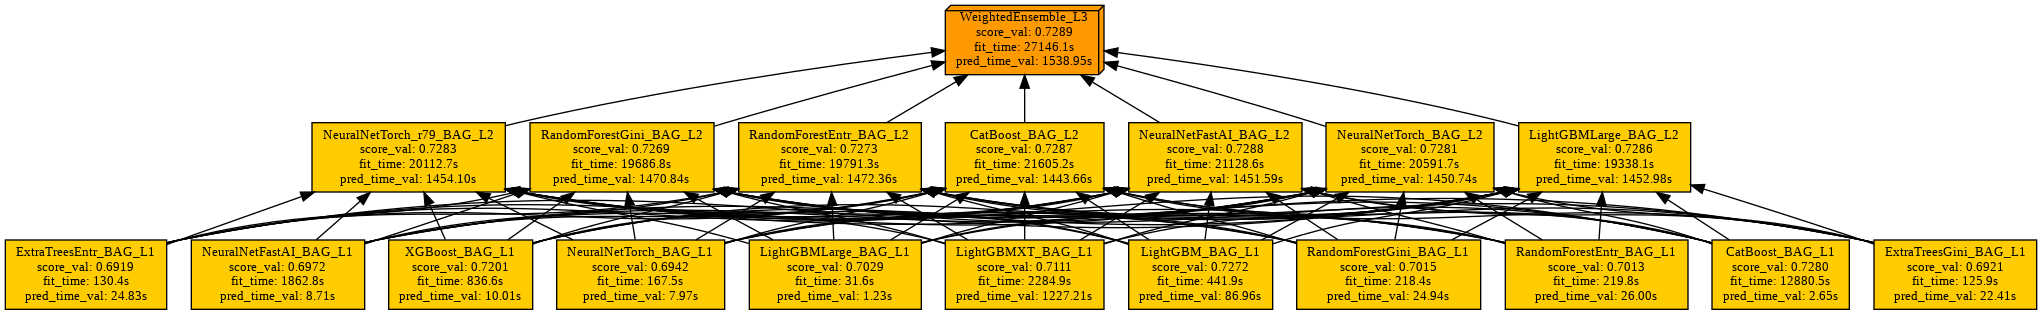

In [19]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image(f'{MODELS_PATH}ensemble_model.png'))

In [20]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
# !zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

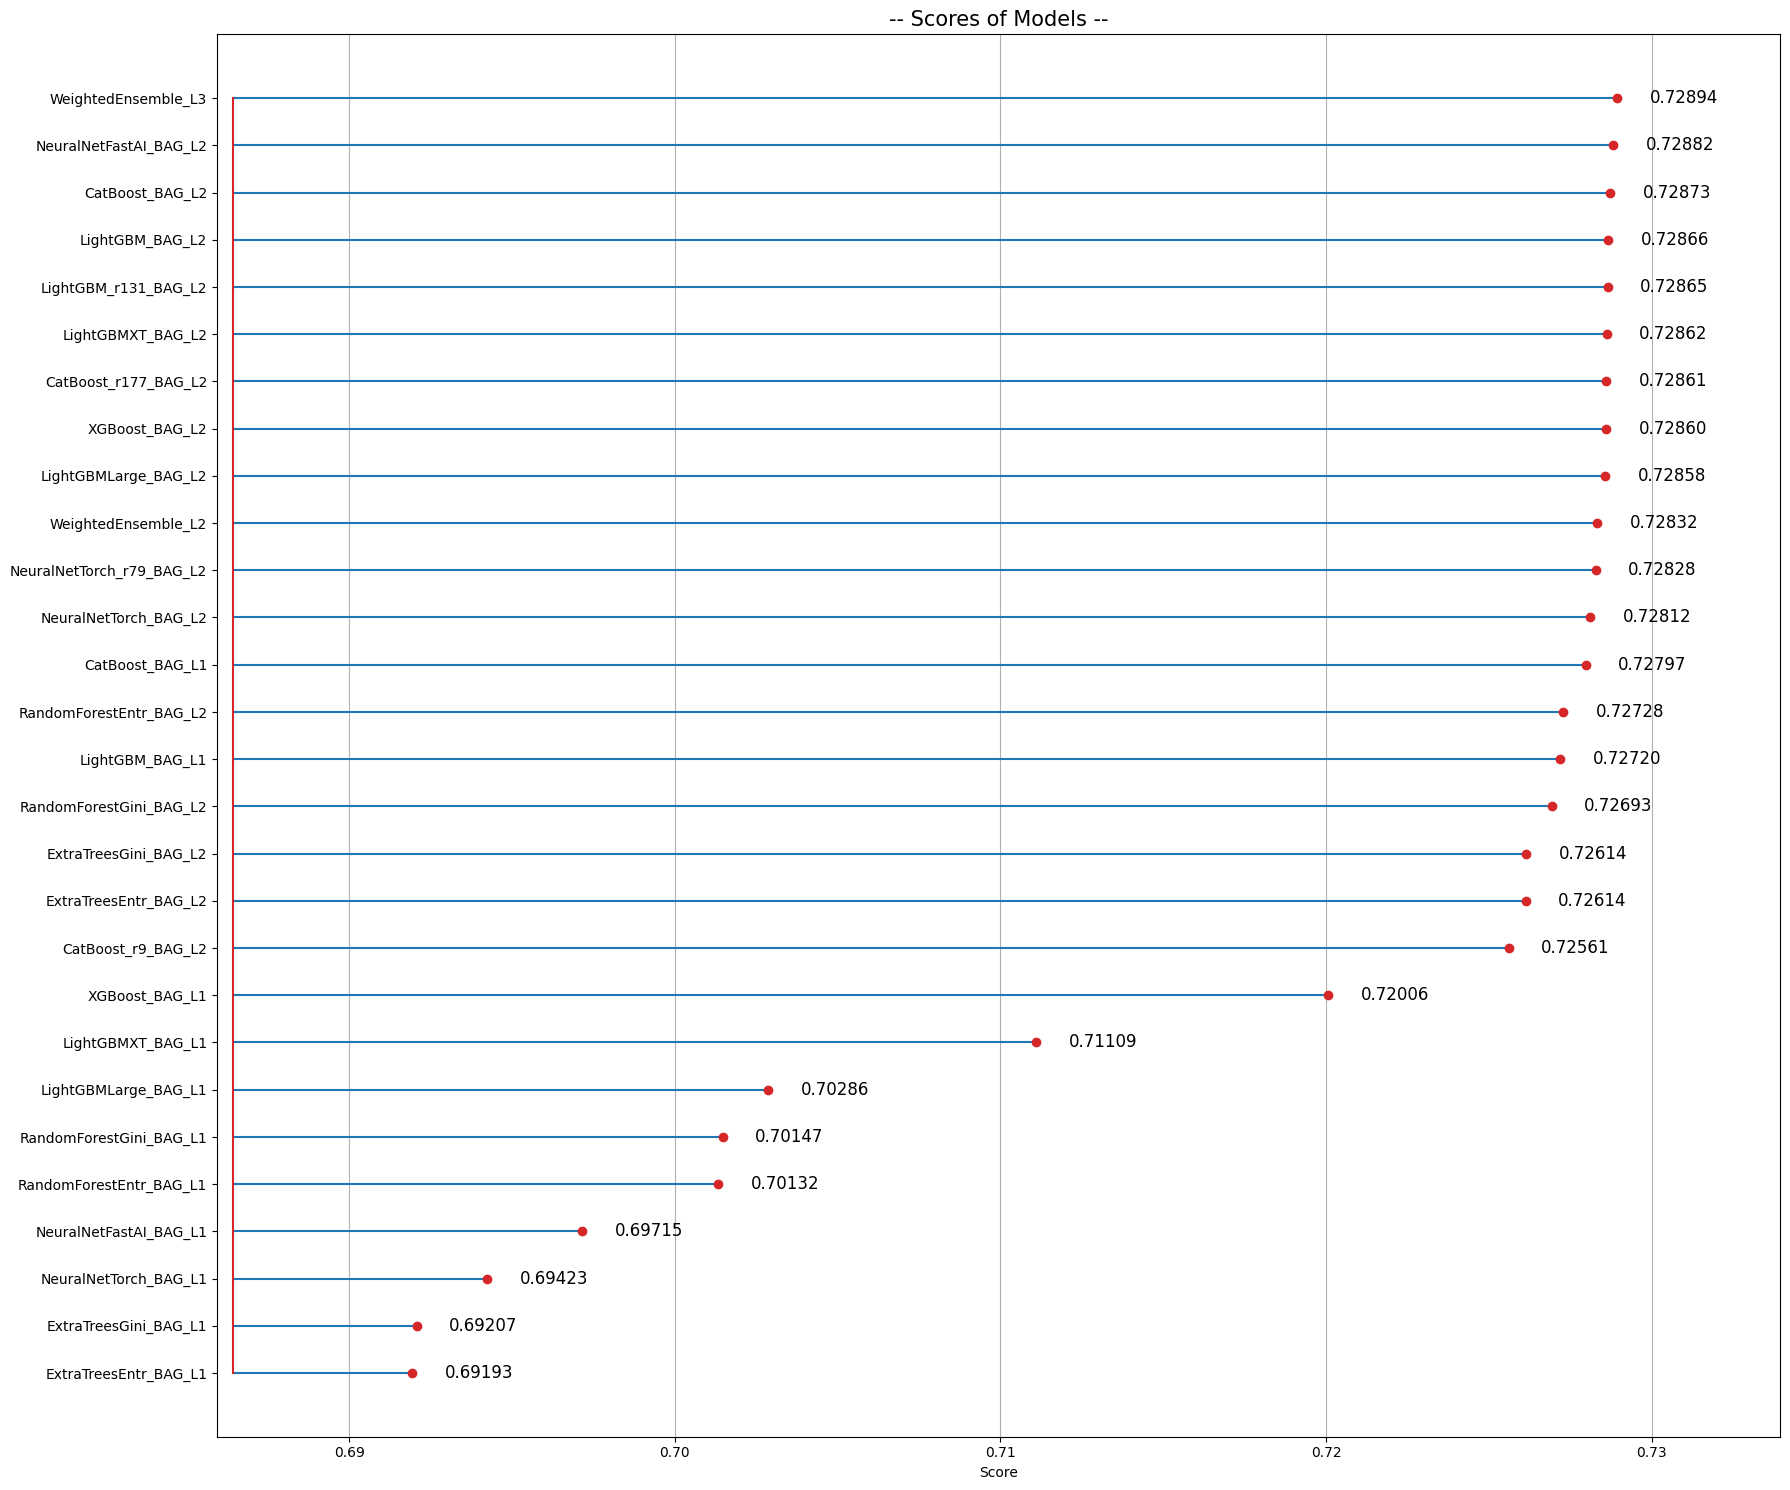

In [21]:
## -- Extract model scores --
result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 15))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.005)
plt.xlabel('Score')
plt.title('-- Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontdict=dict(size=12))

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [22]:
# predictor.model_names()

In [23]:
# ## -- Permutation Feature Importances --
# feat_imp = predictor.feature_importance(
#                         data = X_test,
#                         # time_limit = 3600,
#                         # model = 'LightGBM_BAG_L1',
#                         # features = None,
#                         # feature_stage = 'transformed',
#                         # subsample_size = 5000,
#                         # num_shuffle_sets = 10,
#                         # include_confidence_band = True,
#                         confidence_level = 0.95,
#                         # silent = False
# ) 

# feat_imp.style.background_gradient(subset=["importance"], cmap="Spectral")

# plt.figure(figsize=(18, 35))
# sns.barplot(data=feat_imp, y=feat_imp.index, x=feat_imp.importance)
# plt.tick_params(axis='y', which='major', labelcolor='r')
# plt.title("Top Features by Permutation")
# plt.tight_layout()
# plt.show()

In [24]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------



In [25]:
## -- OPTIONAL: Remove stored files --
!rm -r {MODELS_PATH}